In [1]:
import os
import spacy
import string
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle as pkl
from nltk import ngrams
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

## 0. Hyperparameters

In [2]:
learning_rate = 0.01
max_vocab_size = 10000 # number words in the vocabulary base
MAX_SENTENCE_LENGTH = 400
emb_dim = 400 # dimension for n-gram embedding
num_epochs = 5 # number epoch to train
BATCH_SIZE = 32 

## 1. Data Split

In [3]:
train_path = '/Users/yi/Documents/DS1011/hw1/data/aclImdb/train'
test_path = '/Users/yi/Documents/DS1011/hw1/data/aclImdb/test'

def readfiles(path):
    signset = ['pos','neg']
    dataset = []
    targets = []
    for sign in signset: 
        files = os.listdir(path+'/' + sign)
        if sign == 'pos':
            target = 1
        else:
            target = 0
        for file in files:
            f = open(path+'/'+sign +'/'+file)
            iter_f = iter(f)
            tmp = ''
            for line in iter_f:
                tmp += line
            dataset.append(tmp)
            targets.append(target)
    return [dataset,targets]


In [4]:
train_x,train_y = readfiles(train_path)
train_x,val_x,train_y,val_y = train_test_split(train_x, train_y, test_size=0.2,random_state = 1)
test_x,test_y = readfiles(test_path)

## 2. Tokenization

In [6]:

tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
# to delete common words
def isCommon(ngram):
    commonWords = ["the", "be", "and", "of", "a", "in", "to", "have",
                   "it", "i", "that", "for", "you", "he", "with", "on", "do", "say",
                   "this", "they", "is", "an", "at", "but","we", "his", "from", "that",
                   "by", "she", "or", "as", "what", "go", "their","can", "who",
                   "get", "if", "would", "her", "all", "my", "make", "about", "know",
                   "will","as", "up", "one", "time", "has", "been", "there", "year", "so",
                   "think", "when", "which", "them", "some", "me", "people", "take", "out",
                   "into", "just", "see", "him", "your", "come", "could", "now", "than",
                   "like", "other", "how", "then", "its", "our", "two", "more", "these",
                   "want", "way", "look", "first", "also", "new", "because", "day", "more",
                   "use", "man", "find", "here", "thing", "give", "many", "well"]

    return True if ngram in commonWords else False

# lowercase and remove punctuation 
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if ((token.text not in punctuations) and (not isCommon(token.text.lower())))]

In [7]:
#tokenize dataset for ngrams
def tokenize_ngram(dataset,n):
    token_dataset = []
    all_tokens = []
    for sample in dataset:
        tokens = tokenize(sample)
        if n == 1:
            token_dataset.append(tokens)
            all_tokens += tokens
        else:
            ngram_tokens = ngrams(tokens,n)
            tmp = [c for c in ngram_tokens]
            token_dataset.append(tmp)
            all_tokens += tmp
    return token_dataset, all_tokens

In [ ]:
for i in range(1,5):
    print ("Tokenizing train data with "+str(i)+" gram(s)")
    train_data_tokens, all_train_tokens = tokenize_ngram(train_x,i)
    pkl.dump(train_data_tokens, open("train_data_tokens_"+str(i)+".p", "wb"))
    pkl.dump(all_train_tokens, open("all_train_tokens_"+str(i)+".p", "wb"))
    print ("Tokenizing val data with "+str(i)+" gram(s)")
    val_data_tokens, _ = tokenize_ngram(val_x,i)
    pkl.dump(val_data_tokens, open("val_data_tokens_"+str(i)+".p", "wb"))
    # test set tokens
    print ("Tokenizing test data with "+str(i)+" gram(s)")
    test_data_tokens, _ = tokenize_ngram(test_x,i)
    pkl.dump(test_data_tokens, open("test_data_tokens_"+str(i)+".p", "wb"))
    print('')
    

In [8]:
def build_vocab(all_tokens,max_vocab_size = 10000, PAD_IDX = 0,UNK_IDX = 1):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token


In [20]:

def token2index_dataset(tokens_data,token2id):
    indices_data = []
    for tokens in tokens_data:
        for token in tokens:
            index_list = []
            if token in token2id:
                index_list.append(token2id[token])
            else:
                index_list.append(1)#UNK_IDX
        indices_data.append(index_list)
    return indices_data


In [11]:
############# code from lab3, DS1011##################
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]
# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)


## 3. Model

In [12]:
class Ngrams(nn.Module):
    #2-class classification
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(Ngrams, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [13]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]       
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

## 4. Parameter Tuning

In [ ]:
learning_rate = [0.01]
max_vocab_size = [10000] # number words in the vocabulary base
MAX_SENTENCE_LENGTH = [200]
emb_dim = [100] # dimension for n-gram embedding
num_epochs = [50] # number epoch to train
BATCH_SIZE = 32 
ngram_n = [1] 
optimizer_list = []

In [56]:
criterion = torch.nn.CrossEntropyLoss()
def grid_search(Ngrams,ngram_list,optimizer_list, learning_rate_list,
               emb_dim_list, max_vocab_list,acc_dictionary,loss_dictionary,lalr = False,num_epochs = 5):
        train_losslist = []
        val_acclist = []
        for n_grams in ngram_list:
            train_data_tokens = pkl.load(open("train_data_tokens_"+str(n_grams)+".p", "rb"))
            all_train_tokens = pkl.load(open("all_train_tokens_"+str(n_grams)+".p", "rb"))
            val_data_tokens = pkl.load(open("val_data_tokens_"+str(n_grams)+".p", "rb"))
            test_data_tokens = pkl.load(open("test_data_tokens_"+str(n_grams)+".p", "rb"))
            for max_vocab_size in max_vocab_list:
                token2id, id2token = build_vocab(all_train_tokens,max_vocab_size = max_vocab_size)
                train_data_indices = token2index_dataset(train_data_tokens,token2id)
                val_data_indices = token2index_dataset(val_data_tokens,token2id)
                test_data_indices = token2index_dataset(test_data_tokens,token2id)
                train_dataset = NewsGroupDataset(train_data_indices, train_y)
                train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
                val_dataset = NewsGroupDataset(val_data_indices, val_y)
                val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
                test_dataset = NewsGroupDataset(test_data_indices, test_y)
                test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)
                for emb_dim in emb_dim_list:
                    for learning_rate in learning_rate_list:
                        for opt in optimizer_list:
                            model = Ngrams(len(id2token), emb_dim)
                            if opt == 'SGD':
                                optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
                            elif opt == 'Adam':
                                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                             
                            val_acclist = []
                            train_losslist = []
                            for epoch in range(num_epochs):
                                if lalr:
                                    lr = learning_rate * (0.1 ** (epoch // 2))
                                    for param_group in optimizer.param_groups:
                                        param_group['lr'] = lr
                                for i, (data, lengths, labels) in enumerate(train_loader):            
                                    model.train()
                                    data_batch, length_batch, label_batch = data, lengths, labels
                                    optimizer.zero_grad()
                                    #print(type(data_batch), type(length_batch))
                                    outputs = model(data_batch, length_batch)
                                    loss = criterion(outputs, label_batch)
                                    loss.backward()
                                    optimizer.step()
                                    # validate every 100 iterations
                                    if i > 0 and i % 100 == 0:
                                    # validate
                                        val_acc = test_model(val_loader, model)
                                        val_acclist.append(val_acc)
                                        train_losslist.append((100.0 - test_model(train_loader, model)))
                                        print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Loss: {}'.format( 
                                       epoch+1, num_epochs, i+1, len(train_loader), val_acclist[-1],train_losslist[-1]))
                                
                            acc_dictionary['n_grams:' +str(n_grams)+' lr:'+str(learning_rate)+' lalr:'+str(lalr)+' num_epochs:'+str(epoch)+
                                        ' optimizer:'+opt+' emb_dim:'+str(emb_dim)+' vocab_size:'+str(len(id2token))] = val_acclist
                            loss_dictionary['n_grams:' +str(n_grams)+' lr:'+str(learning_rate)+' lalr:'+str(lalr)+' num_epochs:'+str(epoch)+
                                        ' optimizer:'+opt+' emb_dim:'+str(emb_dim)+' vocab_size:'+str(len(id2token))] = train_losslist
                            model.zero_grad()
                            del(model)    
        return acc_dict,loss_dict

###  n-grams

In [69]:
acc_dict = {}
loss_dict = {}
ngram_list = [1,2,3,4]
optimizer_list = ['Adam']
learning_rate_list = [0.01]
emb_dim_list = [50]
max_vocab_list = [10000]
grid_search(Ngrams,ngram_list,optimizer_list,learning_rate_list,emb_dim_list,max_vocab_list,acc_dict,loss_dict,lalr = False);


Epoch: [1/5], Step: [101/625], Validation Acc: 83.52000000000001, Train Loss: 8.922
Epoch: [1/5], Step: [201/625], Validation Acc: 86.24000000000001, Train Loss: 8.1
Epoch: [1/5], Step: [301/625], Validation Acc: 87.28, Train Loss: 7.817
Epoch: [1/5], Step: [401/625], Validation Acc: 88.92, Train Loss: 7.506
Epoch: [1/5], Step: [501/625], Validation Acc: 88.84, Train Loss: 7.155000000000001
Epoch: [1/5], Step: [601/625], Validation Acc: 88.34, Train Loss: 7.052000000000001
Epoch: [2/5], Step: [101/625], Validation Acc: 89.5, Train Loss: 6.701
Epoch: [2/5], Step: [201/625], Validation Acc: 88.02000000000001, Train Loss: 6.690000000000001
Epoch: [2/5], Step: [301/625], Validation Acc: 88.47999999999999, Train Loss: 6.538
Epoch: [2/5], Step: [401/625], Validation Acc: 89.03999999999999, Train Loss: 6.384
Epoch: [2/5], Step: [501/625], Validation Acc: 89.58, Train Loss: 6.401
Epoch: [2/5], Step: [601/625], Validation Acc: 89.88, Train Loss: 6.302000000000001
Epoch: [3/5], Step: [101/625], 

Epoch: [3/5], Step: [301/625], Validation Acc: 79.84, Train Loss: 9.814
Epoch: [3/5], Step: [401/625], Validation Acc: 80.74000000000001, Train Loss: 9.792000000000002
Epoch: [3/5], Step: [501/625], Validation Acc: 79.84, Train Loss: 9.815000000000001
Epoch: [3/5], Step: [601/625], Validation Acc: 80.75999999999999, Train Loss: 9.789000000000001
Epoch: [4/5], Step: [101/625], Validation Acc: 80.75999999999999, Train Loss: 9.788
Epoch: [4/5], Step: [201/625], Validation Acc: 80.72, Train Loss: 9.790000000000001
Epoch: [4/5], Step: [301/625], Validation Acc: 79.82, Train Loss: 9.812000000000001
Epoch: [4/5], Step: [401/625], Validation Acc: 79.86, Train Loss: 9.812000000000001
Epoch: [4/5], Step: [501/625], Validation Acc: 79.82, Train Loss: 9.811
Epoch: [4/5], Step: [601/625], Validation Acc: 80.75999999999999, Train Loss: 9.788
Epoch: [5/5], Step: [101/625], Validation Acc: 79.88, Train Loss: 9.811
Epoch: [5/5], Step: [201/625], Validation Acc: 79.84, Train Loss: 9.813
Epoch: [5/5], St

### 4.1 tokenization+ngram

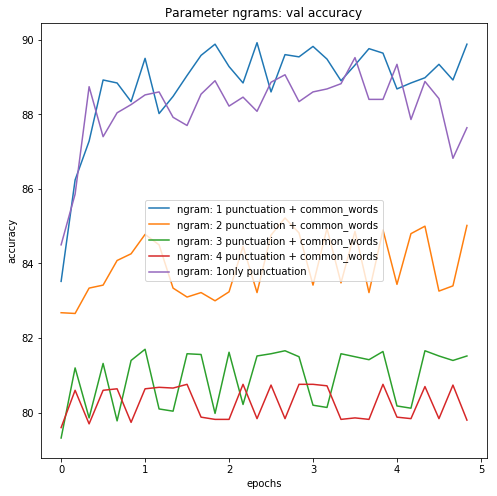

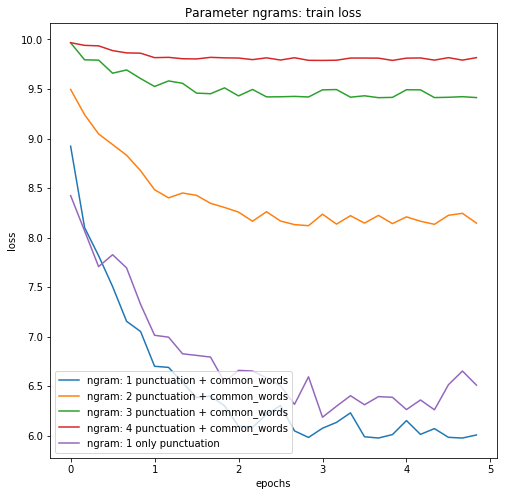

In [70]:
##additional 2 y's are from tokenization_permutation.ipython file
xpts = np.arange(0 ,num_epochs, 1/6).reshape(-1,1)
fig,ax=plt.subplots(figsize=(8,8))
lines=locals()
i = 0
for ngrams in ngram_list:
    y = acc_dict[list(acc_dict.keys())[i]]
    label = "ngram: "+str(ngrams)+' punctuation + common_words'
    lines[label],=ax.plot(xpts, y, label=label)
    i += 1
y = [84.5,85.86,88.74000000000001,87.4,88.03999999999999,88.25999999999999,88.52000000000001,88.6,87.92,87.7,88.53999999999999,
  88.9,88.22,88.46000000000001,88.08,88.86,89.06,88.34,88.6,88.68,88.82,89.52000000000001,88.4,88.4,89.34,87.86,88.88,
  88.42,86.82,87.64]
label = "ngram: "+str(1)+'only punctuation'
lines[label],=ax.plot(xpts, y, label=label)
ax.legend(loc = 'best')
plt.title('Parameter ngrams: val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

fig,ax=plt.subplots(figsize=(8,8))
lines=locals()
i = 0
for ngrams in ngram_list:
    y = loss_dict[list(loss_dict.keys())[i]]
    label = "ngram: "+str(ngrams)+' punctuation + common_words'
    lines[label],=ax.plot(xpts, y, label=label)
    i += 1
y = [8.424,8.067,7.707,7.827,7.694,7.3260000000000005,7.013999999999999,6.994999999999999,6.827000000000002,
  6.811000000000002,6.7940000000000005,6.541,6.66,6.6530000000000005,6.5840000000000005,6.505000000000002,
  6.316999999999999,6.594999999999999,6.187000000000001,6.297999999999999,6.404,6.313,6.395,6.388,6.263999999999999,
  6.3610000000000015,6.2620000000000005,6.515000000000001,6.6530000000000005,6.511000000000002]
label = "ngram: "+str(1)+' only punctuation'
lines[label],=ax.plot(xpts, y, label=label)
ax.legend(loc = 'best')
plt.title('Parameter ngrams: train loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### 4.2 optimizer

In [57]:
acc_dict_opt = {}
loss_dict_opt = {}
ngram_list = [1]
optimizer_list = ['Adam','SGD']
learning_rate_list = [0.01]
emb_dim_list = [50]
max_vocab_list = [10000]
grid_search(Ngrams,ngram_list,optimizer_list,learning_rate_list,emb_dim_list,max_vocab_list,acc_dict_opt,loss_dict_opt,lalr = False,num_epochs = 5);


Epoch: [1/5], Step: [101/625], Validation Acc: 84.75999999999999, Train Loss: 9.025
Epoch: [1/5], Step: [201/625], Validation Acc: 86.34, Train Loss: 8.615
Epoch: [1/5], Step: [301/625], Validation Acc: 87.62, Train Loss: 7.665000000000001
Epoch: [1/5], Step: [401/625], Validation Acc: 87.38, Train Loss: 7.8420000000000005
Epoch: [1/5], Step: [501/625], Validation Acc: 89.22, Train Loss: 7.188999999999999
Epoch: [1/5], Step: [601/625], Validation Acc: 89.02000000000001, Train Loss: 6.882
Epoch: [2/5], Step: [101/625], Validation Acc: 88.97999999999999, Train Loss: 6.744
Epoch: [2/5], Step: [201/625], Validation Acc: 88.94, Train Loss: 6.531000000000001
Epoch: [2/5], Step: [301/625], Validation Acc: 89.18, Train Loss: 6.474000000000001
Epoch: [2/5], Step: [401/625], Validation Acc: 89.02000000000001, Train Loss: 6.359000000000001
Epoch: [2/5], Step: [501/625], Validation Acc: 89.14, Train Loss: 6.328
Epoch: [2/5], Step: [601/625], Validation Acc: 89.28, Train Loss: 6.318000000000001
Epo

dict_keys(['n_grams:1 lr:0.01 lalr:False num_epochs:4 optimizer:Adam emb_dim:50 vocab_size:10002', 'n_grams:1 lr:0.01 lalr:False num_epochs:4 optimizer:SGD emb_dim:50 vocab_size:10002'])
dict_keys(['n_grams:1 lr:0.01 lalr:False num_epochs:4 optimizer:Adam emb_dim:50 vocab_size:10002', 'n_grams:1 lr:0.01 lalr:False num_epochs:4 optimizer:SGD emb_dim:50 vocab_size:10002'])


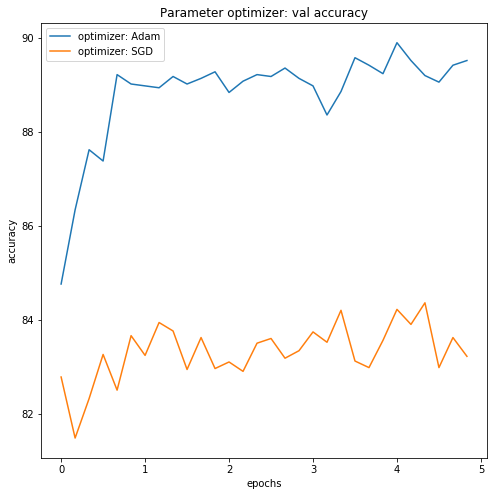

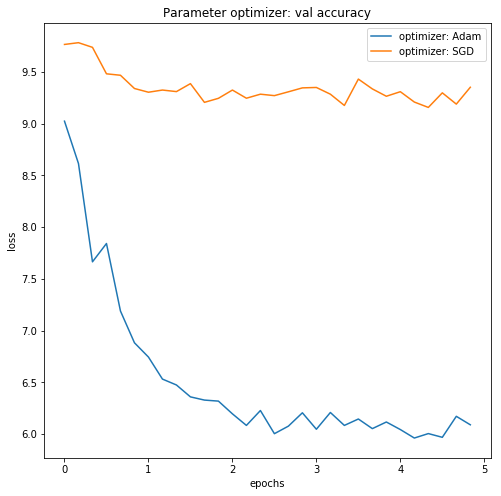

In [58]:
xpts = np.arange(0 ,num_epochs, 1/6).reshape(-1,1)
fig,ax=plt.subplots(figsize=(8,8))
lines=locals()
i = 0
for opt in optimizer_list:
    y = acc_dict_opt[list(acc_dict_opt.keys())[i]][:30]
    label = "optimizer: "+str(opt)
    lines[label],=ax.plot(xpts, y, label=label)
    i += 1

ax.legend(loc = 'best')
plt.title('Parameter optimizer: val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

fig,ax=plt.subplots(figsize=(8,8))
lines=locals()
i = 0
for opt in optimizer_list:
    y = loss_dict_opt[list(loss_dict_opt.keys())[i]][:30]
    label = "optimizer: "+str(opt)
    lines[label],=ax.plot(xpts, y, label=label)
    i += 1
ax.legend(loc = 'best')
plt.title('Parameter optimizer: val accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### 4.3 learning rate

In [60]:
acc_dict_lr = {}
loss_dict_lr = {}
ngram_list = [1]
optimizer_list = ['Adam']
learning_rate_list = [0.01,0.005]
emb_dim_list = [100]
max_vocab_list = [10000]

grid_search(Ngrams,ngram_list,optimizer_list,learning_rate_list,emb_dim_list,max_vocab_list,acc_dict_lr,loss_dict_lr,lalr = False)
grid_search(Ngrams,ngram_list,optimizer_list,learning_rate_list,emb_dim_list,max_vocab_list,acc_dict_lr,loss_dict_lr,lalr = True)

Epoch: [1/5], Step: [101/625], Validation Acc: 84.75999999999999, Train Loss: 8.703000000000001
Epoch: [1/5], Step: [201/625], Validation Acc: 85.7, Train Loss: 8.264000000000001
Epoch: [1/5], Step: [301/625], Validation Acc: 87.06, Train Loss: 7.7250000000000005
Epoch: [1/5], Step: [401/625], Validation Acc: 87.53999999999999, Train Loss: 7.331
Epoch: [1/5], Step: [501/625], Validation Acc: 87.2, Train Loss: 7.373000000000001
Epoch: [1/5], Step: [601/625], Validation Acc: 88.9, Train Loss: 6.884
Epoch: [2/5], Step: [101/625], Validation Acc: 87.7, Train Loss: 6.75
Epoch: [2/5], Step: [201/625], Validation Acc: 88.52000000000001, Train Loss: 6.544999999999999
Epoch: [2/5], Step: [301/625], Validation Acc: 88.12, Train Loss: 6.755000000000002
Epoch: [2/5], Step: [401/625], Validation Acc: 88.78, Train Loss: 6.513
Epoch: [2/5], Step: [501/625], Validation Acc: 88.68, Train Loss: 6.541999999999999
Epoch: [2/5], Step: [601/625], Validation Acc: 88.9, Train Loss: 6.322
Epoch: [3/5], Step: [

Epoch: [2/5], Step: [501/625], Validation Acc: 89.92, Train Loss: 6.515000000000001
Epoch: [2/5], Step: [601/625], Validation Acc: 89.66, Train Loss: 6.516
Epoch: [3/5], Step: [101/625], Validation Acc: 89.97999999999999, Train Loss: 6.282
Epoch: [3/5], Step: [201/625], Validation Acc: 90.32, Train Loss: 6.169999999999999
Epoch: [3/5], Step: [301/625], Validation Acc: 90.82, Train Loss: 6.062000000000001
Epoch: [3/5], Step: [401/625], Validation Acc: 90.88, Train Loss: 6.06
Epoch: [3/5], Step: [501/625], Validation Acc: 90.52000000000001, Train Loss: 5.9860000000000015
Epoch: [3/5], Step: [601/625], Validation Acc: 90.6, Train Loss: 6.002000000000002
Epoch: [4/5], Step: [101/625], Validation Acc: 90.12, Train Loss: 5.974000000000001
Epoch: [4/5], Step: [201/625], Validation Acc: 90.74000000000001, Train Loss: 5.943000000000001
Epoch: [4/5], Step: [301/625], Validation Acc: 90.56, Train Loss: 5.938999999999999
Epoch: [4/5], Step: [401/625], Validation Acc: 90.72, Train Loss: 5.965000000

({'n_grams:1 lr:0.01 lalr:False num_epochs:0 optimizer:Adam emb_dim:50 vocab_size:10002': [82.0,
   84.92,
   86.52000000000001,
   87.46000000000001,
   88.06,
   88.2,
   87.92,
   89.82,
   88.52000000000001,
   89.62,
   88.4,
   89.94,
   89.24000000000001,
   88.86,
   89.24000000000001,
   89.12,
   89.88,
   89.34,
   89.22,
   88.84,
   89.44,
   88.75999999999999,
   89.02000000000001,
   89.36,
   89.32,
   88.96000000000001,
   89.5,
   89.4,
   89.58,
   89.47999999999999],
  'n_grams:1 lr:0.01 lalr:False num_epochs:1 optimizer:Adam emb_dim:50 vocab_size:10002': [82.0,
   84.92,
   86.52000000000001,
   87.46000000000001,
   88.06,
   88.2,
   87.92,
   89.82,
   88.52000000000001,
   89.62,
   88.4,
   89.94,
   89.24000000000001,
   88.86,
   89.24000000000001,
   89.12,
   89.88,
   89.34,
   89.22,
   88.84,
   89.44,
   88.75999999999999,
   89.02000000000001,
   89.36,
   89.32,
   88.96000000000001,
   89.5,
   89.4,
   89.58,
   89.47999999999999],
  'n_grams:1 lr:

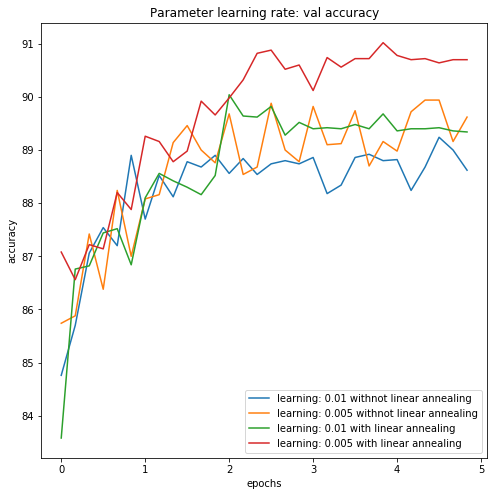

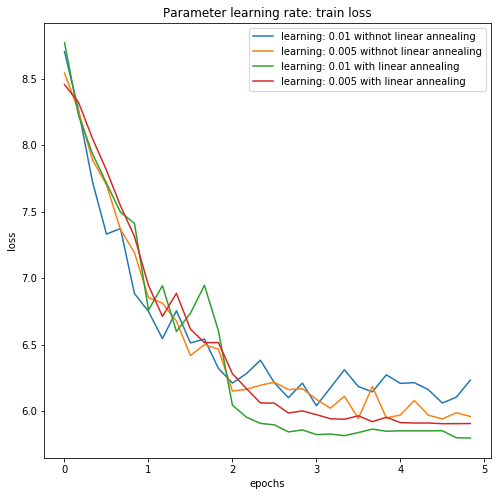

In [66]:
learning_rate_list = [0.01,0.005]
fig,ax=plt.subplots(figsize=(8,8))
lines=locals()
i = 0
for j in ['withnot','with']:
    for k in learning_rate_list:
    
        y = acc_dict_lr[list(acc_dict_lr.keys())[i]]
        label = "learning: "+str(k)+' '+j+' linear annealing'
        lines[label],=ax.plot(xpts, y, label=label)
        i += 1
ax.legend(loc = 'best')
plt.title('Parameter learning rate: val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

fig,ax=plt.subplots(figsize=(8,8))
lines=locals()
i = 0
for j in ['withnot','with']:
    for k in learning_rate_list:
        y = loss_dict_lr[list(loss_dict_lr.keys())[i]]
        label = "learning: "+str(k)+' '+j+' linear annealing'
        lines[label],=ax.plot(xpts, y, label=label)
        i += 1
ax.legend(loc = 'best')
plt.title('Parameter learning rate: train loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### 4.4 Embedding_dim

In [63]:
acc_dict_e = {}
loss_dict_e = {}
ngram_list = [1]
optimizer_list = ['Adam']
learning_rate_list = [0.005]
emb_dim_list = [50,100]
max_vocab_list = [10000]

grid_search(Ngrams,ngram_list,optimizer_list,learning_rate_list,emb_dim_list,max_vocab_list,acc_dict_e,loss_dict_e,lalr = False);

Epoch: [1/5], Step: [101/625], Validation Acc: 83.28, Train Loss: 9.187000000000001
Epoch: [1/5], Step: [201/625], Validation Acc: 84.78, Train Loss: 8.711
Epoch: [1/5], Step: [301/625], Validation Acc: 84.42, Train Loss: 8.434000000000001
Epoch: [1/5], Step: [401/625], Validation Acc: 87.02000000000001, Train Loss: 7.9830000000000005
Epoch: [1/5], Step: [501/625], Validation Acc: 87.92, Train Loss: 7.6690000000000005
Epoch: [1/5], Step: [601/625], Validation Acc: 87.58, Train Loss: 7.3629999999999995
Epoch: [2/5], Step: [101/625], Validation Acc: 87.38, Train Loss: 7.185
Epoch: [2/5], Step: [201/625], Validation Acc: 87.8, Train Loss: 6.916999999999999
Epoch: [2/5], Step: [301/625], Validation Acc: 88.8, Train Loss: 6.738999999999999
Epoch: [2/5], Step: [401/625], Validation Acc: 88.47999999999999, Train Loss: 6.77
Epoch: [2/5], Step: [501/625], Validation Acc: 88.8, Train Loss: 6.627000000000002
Epoch: [2/5], Step: [601/625], Validation Acc: 89.44, Train Loss: 6.521000000000001
Epoch

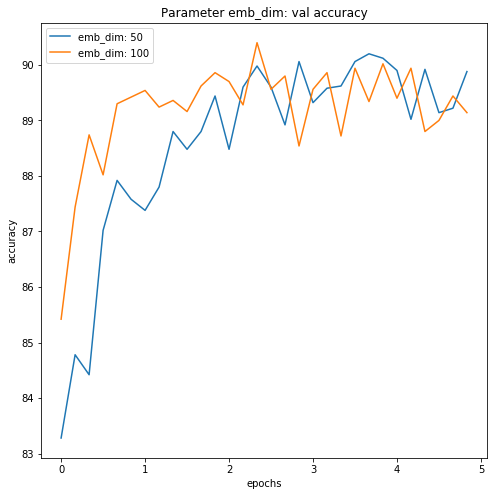

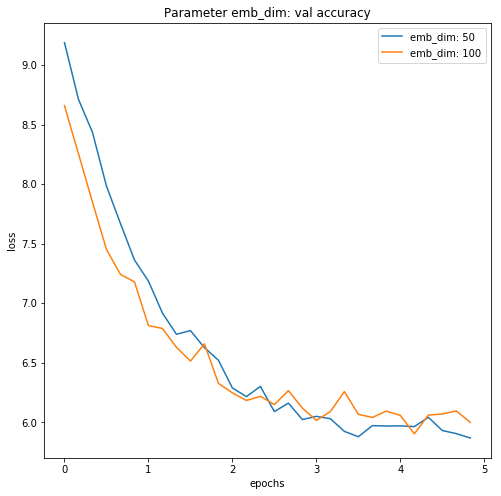

In [64]:
fig,ax=plt.subplots(figsize=(8,8))
lines=locals()
i = 0
for k in emb_dim_list:
    y = acc_dict_e[list(acc_dict_e.keys())[i]][:30]
    label = "emb_dim: "+str(k)
    lines[label],=ax.plot(xpts, y, label=label)
    i += 1

ax.legend(loc = 'best')
plt.title('Parameter emb_dim: val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

fig,ax=plt.subplots(figsize=(8,8))
lines=locals()
i = 0
for k in emb_dim_list:
    y = loss_dict_e[list(loss_dict_e.keys())[i]][:30]
    label = "emb_dim: "+str(k)
    lines[label],=ax.plot(xpts, y, label=label)
    i += 1
ax.legend(loc = 'best')
plt.title('Parameter emb_dim: val accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### 4.5 Vocabulary size

In [67]:
acc_dict_v = {}
loss_dict_v = {}
ngram_list = [1]
optimizer_list = ['Adam']
learning_rate_list = [0.005]
emb_dim_list = [50]
max_vocab_list = [10000,100000]

grid_search(Ngrams,ngram_list,optimizer_list,learning_rate_list,emb_dim_list,max_vocab_list,acc_dict_v,loss_dict_v,lalr = False);

Epoch: [1/5], Step: [101/625], Validation Acc: 85.14, Train Loss: 8.925
Epoch: [1/5], Step: [201/625], Validation Acc: 85.94, Train Loss: 8.454
Epoch: [1/5], Step: [301/625], Validation Acc: 87.06, Train Loss: 8.116
Epoch: [1/5], Step: [401/625], Validation Acc: 87.0, Train Loss: 7.9510000000000005
Epoch: [1/5], Step: [501/625], Validation Acc: 87.92, Train Loss: 7.603000000000001
Epoch: [1/5], Step: [601/625], Validation Acc: 88.12, Train Loss: 7.325
Epoch: [2/5], Step: [101/625], Validation Acc: 88.8, Train Loss: 7.034000000000001
Epoch: [2/5], Step: [201/625], Validation Acc: 88.84, Train Loss: 6.819
Epoch: [2/5], Step: [301/625], Validation Acc: 88.28, Train Loss: 6.77
Epoch: [2/5], Step: [401/625], Validation Acc: 89.32, Train Loss: 6.606999999999999
Epoch: [2/5], Step: [501/625], Validation Acc: 89.66, Train Loss: 6.529
Epoch: [2/5], Step: [601/625], Validation Acc: 89.53999999999999, Train Loss: 6.288999999999999
Epoch: [3/5], Step: [101/625], Validation Acc: 90.46000000000001, 

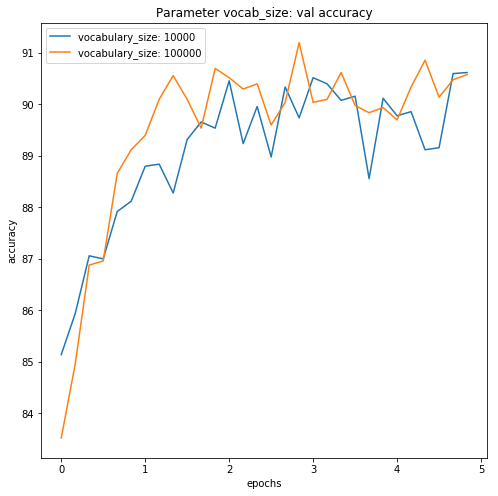

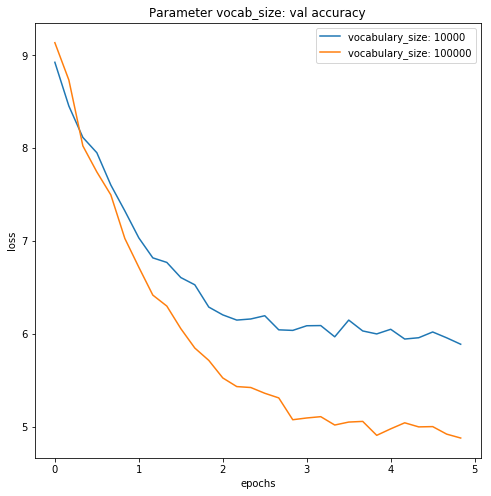

In [68]:
fig,ax=plt.subplots(figsize=(8,8))
lines=locals()
i = 0
for v in max_vocab_list:
    y = acc_dict_v[list(acc_dict_v.keys())[i]][:30]
    label = "vocabulary_size: "+str(v)
    lines[label],=ax.plot(xpts, y, label=label)
    i += 1

ax.legend(loc = 'best')
plt.title('Parameter vocab_size: val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

fig,ax=plt.subplots(figsize=(8,8))
lines=locals()
i = 0
for v in max_vocab_list:
    y = loss_dict_v[list(loss_dict_v.keys())[i]][:30]
    label = "vocabulary_size: "+str(v)
    lines[label],=ax.plot(xpts, y, label=label)
    i += 1
ax.legend(loc = 'best')
plt.title('Parameter vocab_size: val accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## Best model

In [72]:
train_data_tokens = pkl.load(open("train_data_tokens_"+str(1)+".p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_"+str(1)+".p", "rb"))
val_data_tokens = pkl.load(open("val_data_tokens_"+str(1)+".p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_"+str(1)+".p", "rb"))
token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens,token2id)
val_data_indices = token2index_dataset(val_data_tokens,token2id)
test_data_indices = token2index_dataset(test_data_tokens,token2id)
train_dataset = NewsGroupDataset(train_data_indices, train_y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
val_dataset = NewsGroupDataset(val_data_indices, val_y)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
test_dataset = NewsGroupDataset(test_data_indices, test_y)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

In [87]:

def best_model(Ngram,learning_rate,
               emb_dim, max_vocab,lalr = True,num_epochs = 5):
    
    model = Ngram(len(id2token), emb_dim)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    test_acc = []
    for epoch in range(num_epochs):
        #adjust LR
        if lalr == True:
            lr = learning_rate * (0.1 ** (epoch // 2))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            #print(type(data_batch), type(length_batch))
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                test_acc.append(test_model(test_loader, model))
    return test_acc,model
   
test_acc,best_model = best_model(Ngrams,0.005, 5, 50, 100000)
print('test accuracy is: ',test_acc[-1])

test accuracy is:  90.548


In [89]:
def predictor(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    all_predicted = []
    all_label = []
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = [x.item() for x in outputs.max(1, keepdim=True)[1]]
        all_predicted += predicted
        all_label += [x.item() for x in labels]
        
        # total += labels.size(0)
        # correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (all_predicted, all_label)
all_pred, all_lab = predictor(val_loader, best_model)
wrong_pred_recorder = []
right_pred_recorder = []
for i in range(0, 1000):
    if all_pred[i] != all_lab[i]:
        wrong_pred_recorder.append((test_x[i], all_lab[i]))
    else:
        right_pred_recorder.append((test_x[i], all_lab[i]))


### Incorrect

In [90]:
for i,text in enumerate(wrong_pred_recorder):
    print(text)
    if i > 3:
        break

('This is the best 3-D experience Disney has at their themeparks. This is certainly better than their original 1960\'s acid-trip film that was in it\'s place, is leagues better than "Honey I Shrunk The Audience" (and far more fun), barely squeaks by the MuppetVision 3-D movie at Disney-MGM and can even beat the original 3-D "Movie Experience" Captain EO. This film relives some of Disney\'s greatest musical hits from Aladdin, The Little Mermaid, and others, and brought a smile to my face throughout the entire show. This is a totally kid-friendly movie too, unlike "Honey..." and has more effects than the spectacular "MuppetVision"', 1)
("I'm just starting to explore the so far wonderful world of monsieur Ozon. I've seen only 4 films so far, and with the last one in the row it hit me that all of them were in fact about lonely women and their actions. Not a single non-lonely female character out of 12, and all of them bring heavy impact of surroundings.<br /><br />This film is probably the

### Correct

In [91]:
for i,text in enumerate(right_pred_recorder):
    print(text)
    if i > 3:
        break

('Based on an actual story, John Boorman shows the struggle of an American doctor, whose husband and son were murdered and she was continually plagued with her loss. A holiday to Burma with her sister seemed like a good idea to get away from it all, but when her passport was stolen in Rangoon, she could not leave the country with her sister, and was forced to stay back until she could get I.D. papers from the American embassy. To fill in a day before she could fly out, she took a trip into the countryside with a tour guide. "I tried finding something in those stone statues, but nothing stirred in me. I was stone myself." <br /><br />Suddenly all hell broke loose and she was caught in a political revolt. Just when it looked like she had escaped and safely boarded a train, she saw her tour guide get beaten and shot. In a split second she decided to jump from the moving train and try to rescue him, with no thought of herself. Continually her life was in danger. <br /><br />Here is a woman